In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from ast import literal_eval
from matplotlib_venn import venn3
from matplotlib_venn import venn2

# Args

In [2]:
def calc_binding_concordance(df, clonotype_fmt):
    #assert df.size > 0, "df empty"
    gems_per_specificity = df.groupby([clonotype_fmt,'peptide']).gem.count().to_dict()
    df['gems_per_specificity'] = df.set_index([clonotype_fmt,'peptide']).index.map(gems_per_specificity)

    gems_per_clonotype = df.groupby([clonotype_fmt]).gem.count().to_dict()
    df['gems_per_clonotype'] = df[clonotype_fmt].map(gems_per_clonotype)
    
    df['binding_concordance'] = df.gems_per_specificity / df.gems_per_clonotype

In [3]:
def cdr3_lst_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace("'","").split(" ")

def peptide_hla_converter(x):
    return re.findall("\w+\s{1}\w{1}\d+", x.replace("[","").replace("]","").replace("'",""))

converters={'peptide_HLA_lst': peptide_hla_converter, 'cdr3_lst_TRA': cdr3_lst_converter, 'cdr3_lst_TRB': cdr3_lst_converter, 'umi_count_lst_mhc': literal_eval}

In [4]:
EXP = "exp3.2.2"
delta = "50"

In [5]:
concordance_threshold = 0.5

# Input

OBS! version 2.2

In [6]:
library = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/" + EXP + "_TCR/library/CDR3_beta1_29_20.xlsx"

In [7]:
GEMS        = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/" + EXP + "_CAT_IONTORRENT_KMA_AKB/specificity_matrix/peptide_per_clonotype_by_gem_size/ct/umi_delta" + delta + "/exclude_single-chain_TCRs/unique_gems/b2.t1.ecs_False.ess_False.lst"
TCR_BARCODE = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/" + EXP + "_CAT_IONTORRENT_KMA_AKB/tables/tcr_barcode.cleaned.csv"
ORIGINAL    = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/" + EXP + "_TCR/processed/cellranger_out/TCR_VDJ/outs/all_contig_annotations.csv"
SIM_TRA     = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/kernel_similarity_tra.tab"
SIM_TRB     = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/kernel_similarity_trb.tab"

# Load

In [8]:
lib = pd.read_excel(library, names=['cdr3_TRB', 'HLA', 'peptide', 'cdr3_len'])
lib = lib[lib.peptide.isin(lib.peptide.value_counts()[lib.peptide.value_counts() > 100].index)]

In [9]:
unique_gems = np.loadtxt(GEMS, dtype=str)

In [10]:
df = pd.read_csv(TCR_BARCODE, converters=converters)
#df = df[df.gem.isin(unique_gems)]
calc_binding_concordance(df, 'ct')

In [11]:
df['chain_count_TRA'] = df.apply(lambda x: len(x.cdr3_lst_TRA) if x.cdr3_lst_TRA[0] != '' else 0, axis=1)
df['chain_count_TRB'] = df.apply(lambda x: len(x.cdr3_lst_TRB) if x.cdr3_lst_TRB[0] != '' else 0, axis=1)

In [12]:
sim_tra = pd.read_csv(SIM_TRA, index_col=0)
sim_trb = pd.read_csv(SIM_TRB, index_col=0)

In [13]:
tcr_df = pd.read_csv(ORIGINAL)

# Main Verify

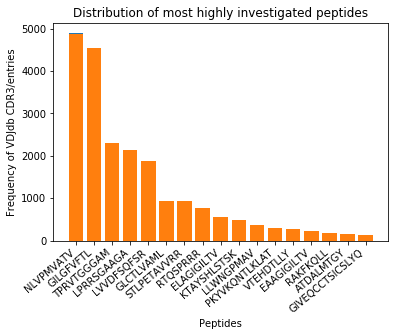

In [14]:
x = lib.peptide.value_counts().index
y = lib.peptide.value_counts().values


plt.bar(x,y)

x = lib.groupby('peptide').cdr3_TRB.unique().apply(len).index
y = lib.groupby('peptide').cdr3_TRB.unique().apply(len).values

plt.bar(x,y)

plt.xticks(rotation=40, ha='right')
plt.xlabel('Peptides')
plt.ylabel('Frequency of VDJdb CDR3/entries')
plt.title('Distribution of most highly investigated peptides')
plt.show()

Verify after imputation? Thus, we get another measure for how likely the imputations are? Or compare before and after? How many of the reference sequences are in the VDJdb?

In [15]:
vdjdb = set(list(zip(lib.cdr3_TRB, lib.peptide)))

In [16]:
df['VDJdb_verified'] = df.apply(lambda x: (x.cdr3_TRB, x.peptide) in vdjdb, axis=1)

# Main reference

In [17]:
query_filter = ((df.multiplets_mhc == 1) &
                (df.chain_count_TRA == 1) &
                (df.chain_count_TRB == 1) & (df.binding_concordance >= concordance_threshold)) #(df.binding_concordance == 1)

In [30]:
# OBS! I am not removing the duplicates
reference = df[query_filter].loc[:, ['gem', 'ct', 'cdr3_TRA', 'cdr3_TRB', 'peptide_HLA', 'peptide', 'umi_count_mhc','umi_count_TRA','umi_count_TRB']]  #.drop_duplicates(subset=['cdr3_TRA', 'cdr3_TRB', 'peptide_HLA']).loc[:, ['gem', 'ct', 'cdr3_TRA', 'cdr3_TRB', 'peptide_HLA', 'peptide', 'umi_count_mhc','umi_count_TRA','umi_count_TRB']]
reference.sort_values(by=['peptide_HLA','cdr3_TRA', 'cdr3_TRB'])

,gem,ct,cdr3_TRA,cdr3_TRB,peptide_HLA,peptide,umi_count_mhc,umi_count_TRA,umi_count_TRB
2037,TCTATTGGTAGCGTAG-1,1128.0,CAVDAGKLIF,CASSQDYNEQFF,AGYLMELCC A0201,AGYLMELCC,1.0,6.0,18.0
1779,GTGCTTCTCATGTCTT-1,115.0,CAMRGPGYSTLTF,CASSQDLLANEQFF,CLLWSFQTSA A0201,CLLWSFQTSA,2.0,2.0,12.0
80,AAGCCGCAGGCTAGAC-1,2241.0,CATDVIQGAQKLVF,CASSLEPSTNTEAFF,CLLWSFQTSA A0201,CLLWSFQTSA,3.0,1.0,9.0
1735,GTCCTCAAGATGTGTA-1,547.0,CAVSPPTDKLIF,CASSGDGVSQPQHF,CLLWSFQTSA A0201,CLLWSFQTSA,1.0,18.0,22.0
2313,TTGTAGGGTTGCTCCT-1,2053.0,CAARLIQGAQKLVF,CASSFRGSGEKLFF,ELAGIGILTV A0201,ELAGIGILTV,2.0,16.0,45.0
...,...,...,...,...,...,...,...,...,...
596,CACAAACTCTTGCCGT-1,2094.0,CALSEPYGGATNKLIF,CASRPWTVNTGELFF,YVLDHLIVV A0201,YVLDHLIVV,4.0,1.0,8.0
597,CACAAACTCTTTCCTC-1,223.0,CAVKDTDKLIF,CASSPILAGVDTQYF,YVLDHLIVV A0201,YVLDHLIVV,1.0,4.0,9.0
1670,GTAACGTTCTGTGCAA-1,223.0,CAVKDTDKLIF,CASSPILAGVDTQYF,YVLDHLIVV A0201,YVLDHLIVV,1.0,4.0,5.0
542,ATTATCCCACTCTGTC-1,461.0,CAVKDTDKLIF,CASSYPGGMSSDGGADTQYF,YVLDHLIVV A0201,YVLDHLIVV,1.0,1.0,14.0


# Main intersections between VDJ, DF and reference

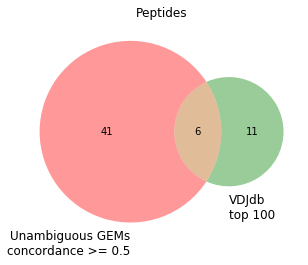

In [19]:
a = set(reference.peptide)
b = set(lib.peptide)

ab = len(a.intersection(b))
a_b = len(a) - ab
b_a = len(b) - ab

title = "Peptides"
venn2(subsets = (a_b, b_a, ab), set_labels = ('Unambiguous GEMs\nconcordance >= %.1f'%concordance_threshold, 'VDJdb\ntop 100'))
plt.title(title)
plt.show()

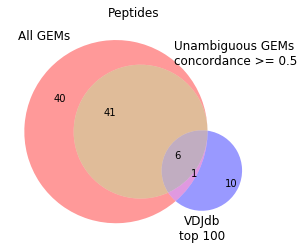

In [20]:
a = set(df.peptide)
b = set(reference.peptide)
c = set(lib.peptide)

ab = a.intersection(b)
ac = a.intersection(c)
bc = b.intersection(c)

abc = len(ab.intersection(c))
ab_c = len(ab) - abc
ac_b = len(ac) - abc
bc_a = len(bc) - abc
a_bc = len(a) - ab_c - ac_b - abc
b_ac = len(b) - ab_c - bc_a - abc
c_ab = len(c) - ac_b - bc_a - abc

venn3(subsets = (a_bc, b_ac, ab_c, c_ab, ac_b, bc_a, abc), set_labels = ('All GEMs', 'Unambiguous GEMs\nconcordance >= %.1f'%concordance_threshold, 'VDJdb\ntop 100'))
title = "Peptides"
plt.title(title)
plt.show()

overlapping_peptides = ac

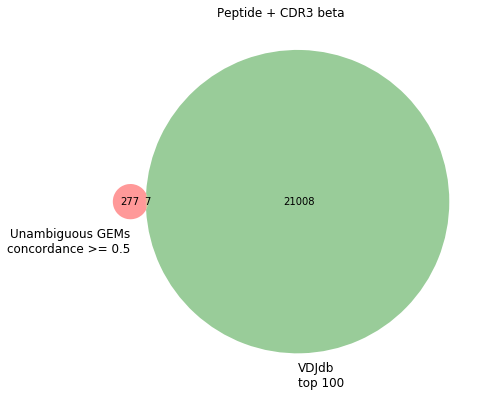

In [21]:
fig = plt.figure(figsize=(7,7))
a = set(list(zip(reference.cdr3_TRB, reference.peptide)))
b = set(list(zip(lib.cdr3_TRB, lib.peptide)))

ab = len(a.intersection(b))
a_b = len(a) - ab
b_a = len(b) - ab

title = "Peptide + CDR3 beta"
venn2(subsets = (a_b, b_a, ab), set_labels = ('Unambiguous GEMs\nconcordance >= %.1f'%concordance_threshold, 'VDJdb\ntop 100'))
plt.title(title)
plt.show()

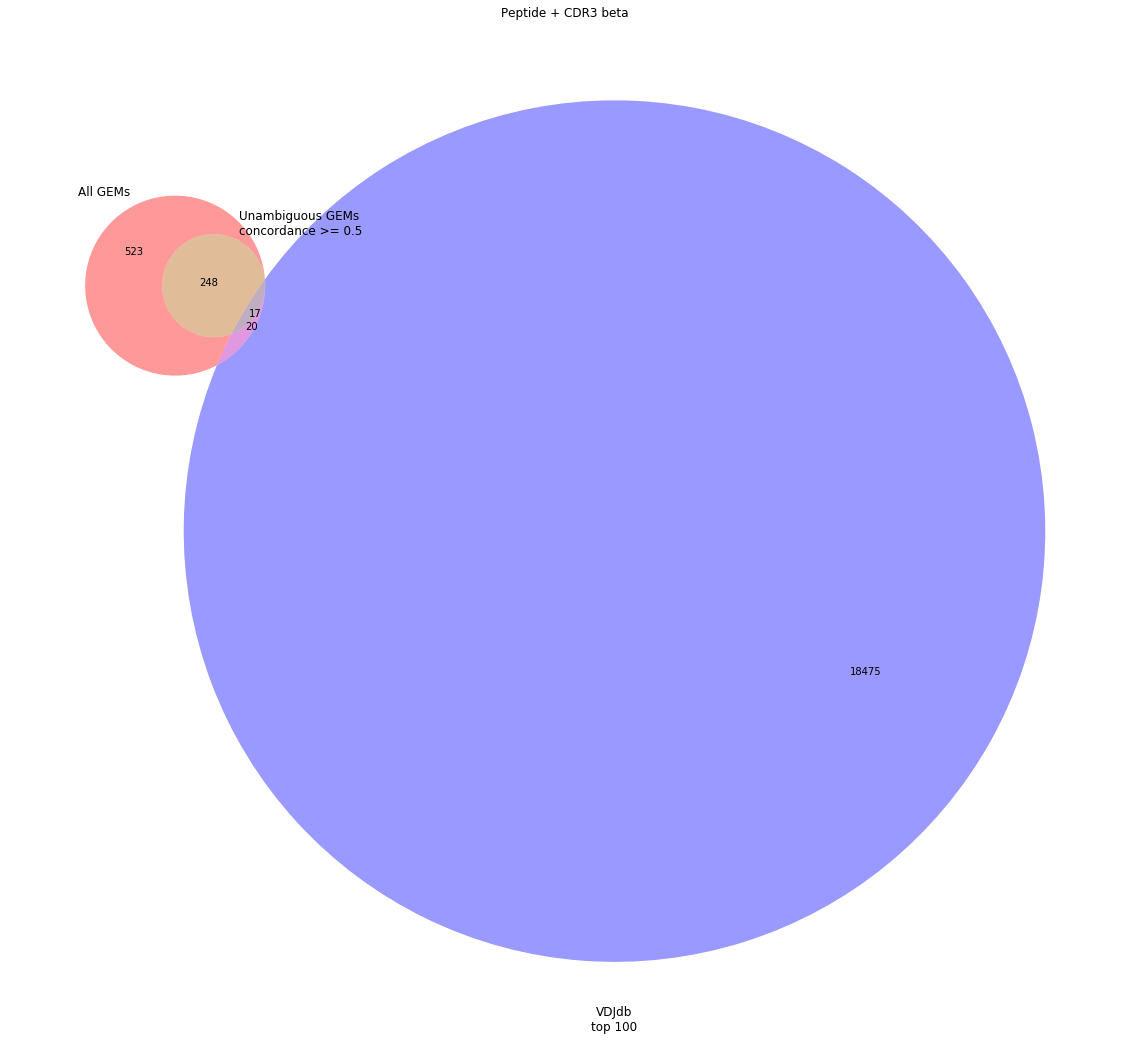

In [22]:
fig = plt.figure(figsize=(20,20))
a = set(df.cdr3_TRB)
b = set(reference.cdr3_TRB)
c = set(lib.cdr3_TRB)

ab = a.intersection(b)
ac = a.intersection(c)
bc = b.intersection(c)

abc = len(ab.intersection(c))
ab_c = len(ab) - abc
ac_b = len(ac) - abc
bc_a = len(bc) - abc
a_bc = len(a) - ab_c - ac_b - abc
b_ac = len(b) - ab_c - bc_a - abc
c_ab = len(c) - ac_b - bc_a - abc

venn3(subsets = (a_bc, b_ac, ab_c, c_ab, ac_b, bc_a, abc), set_labels = ('All GEMs', 'Unambiguous GEMs\nconcordance >= %.1f'%concordance_threshold, 'VDJdb\ntop 100'))
title = "Peptide + CDR3 beta"
plt.title(title)
plt.show()

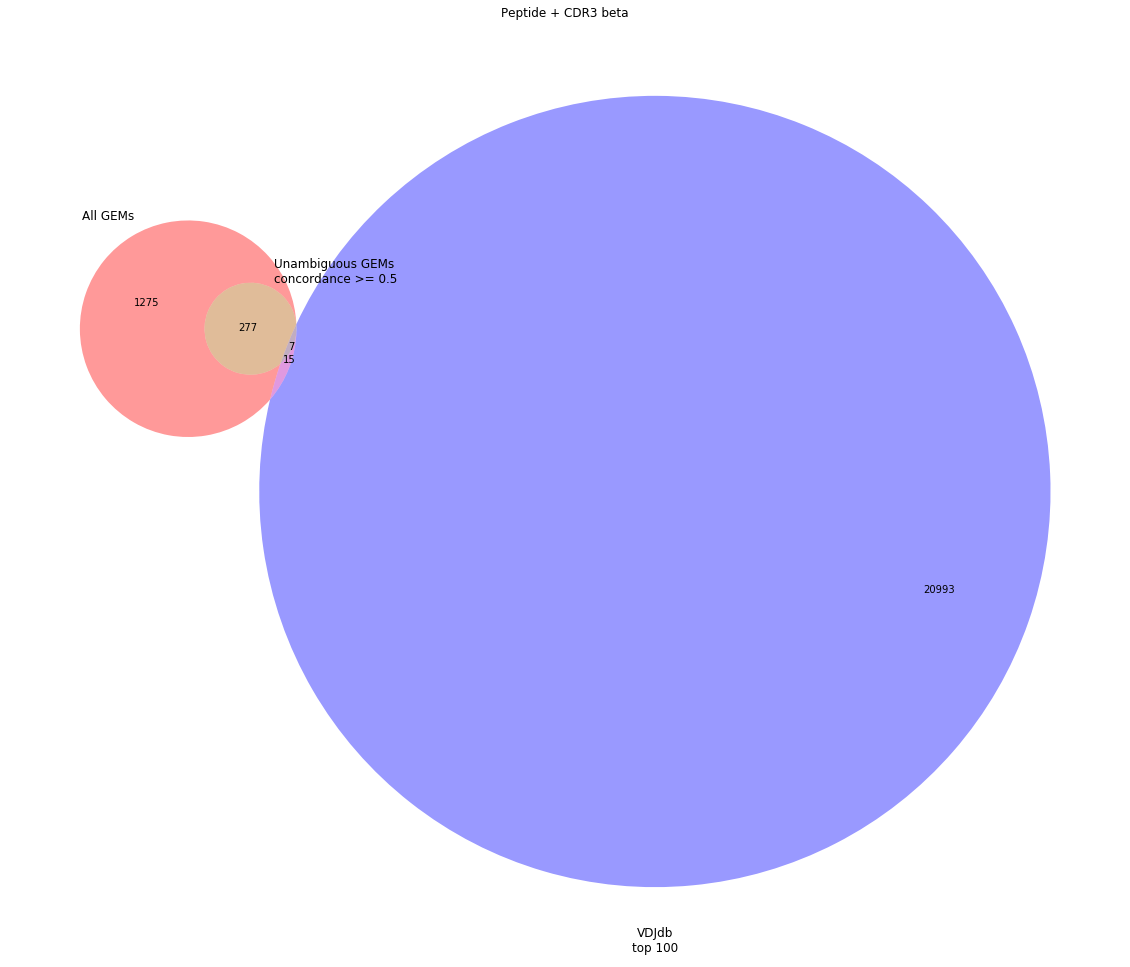

In [23]:
fig = plt.figure(figsize=(20,20))
a = set(list(zip(df.cdr3_TRB, df.peptide)))
b = set(list(zip(reference.cdr3_TRB, reference.peptide)))
c = set(list(zip(lib.cdr3_TRB, lib.peptide)))

ab = a.intersection(b)
ac = a.intersection(c)
bc = b.intersection(c)

abc = len(ab.intersection(c))
ab_c = len(ab) - abc
ac_b = len(ac) - abc
bc_a = len(bc) - abc
a_bc = len(a) - ab_c - ac_b - abc
b_ac = len(b) - ab_c - bc_a - abc
c_ab = len(c) - ac_b - bc_a - abc

venn3(subsets = (a_bc, b_ac, ab_c, c_ab, ac_b, bc_a, abc), set_labels = ('All GEMs', 'Unambiguous GEMs\nconcordance >= %.1f'%concordance_threshold, 'VDJdb\ntop 100'))
title = "Peptide + CDR3 beta"
plt.title(title)
plt.show()

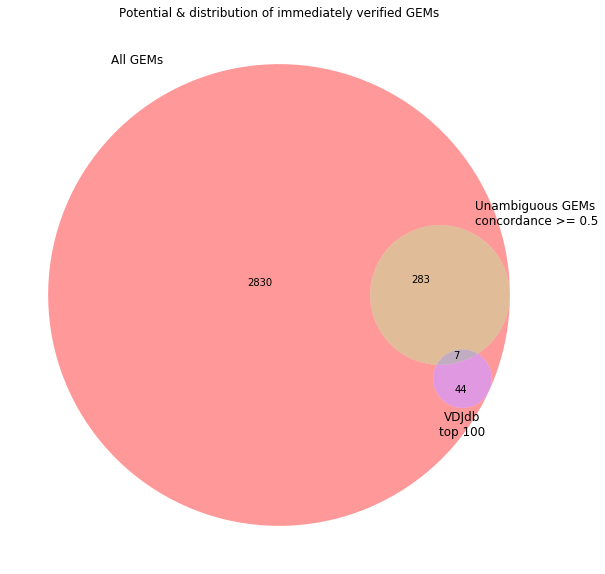

In [24]:
fig = plt.figure(figsize=(10,10))
a = set(df.gem)
b = set(reference.gem) #set(reference.apply(lambda x: x.gem if (x.cdr3_TRB, x.peptide) in vdjdb else None, axis=1).dropna())
c = set(df.apply(lambda x: x.gem if (x.cdr3_TRB, x.peptide) in vdjdb else None, axis=1).dropna())

ab = a.intersection(b)
ac = a.intersection(c)
bc = b.intersection(c)

abc = len(ab.intersection(c))
ab_c = len(ab) - abc
ac_b = len(ac) - abc
bc_a = len(bc) - abc
a_bc = len(a) - ab_c - ac_b - abc
b_ac = len(b) - ab_c - bc_a - abc
c_ab = len(c) - ac_b - bc_a - abc

venn3(subsets = (a_bc, b_ac, ab_c, c_ab, ac_b, bc_a, abc), set_labels = ('All GEMs', 'Unambiguous GEMs\nconcordance >= %.1f'%concordance_threshold, 'VDJdb\ntop 100'))
title = "Potential & distribution of immediately verified GEMs"
plt.title(title)
plt.show()

# Main Impute

### Plots

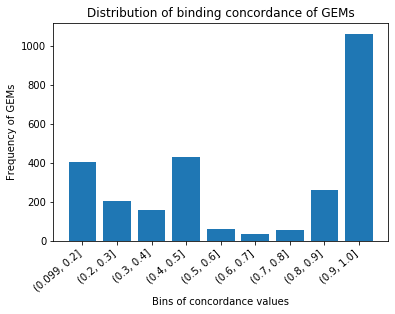

In [25]:
concordance_bins = pd.cut(df.binding_concordance, bins=list(np.arange(0.1,1.1, 0.1)), include_lowest=True)

x = concordance_bins.value_counts(sort=False).index
y = concordance_bins.value_counts(sort=False).values

plt.bar(list(range(len(y))), y)
#plt.xticks([c[1:-1].replace(","," to") for c in concordance_bins.cat.categories.astype(str)])
plt.xticks(list(range(len(y))), concordance_bins.cat.categories.astype(str).to_list(), rotation=40, ha='right')
plt.xlabel('Bins of concordance values')
plt.ylabel('Frequency of GEMs')
plt.title('Distribution of binding concordance of GEMs')
plt.show()

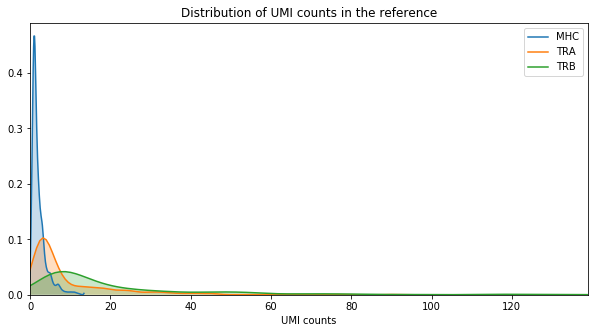

In [59]:
import seaborn as sns
plt.figure(figsize=(10,5))
ax = sns.distplot(reference.umi_count_mhc, hist=False, kde=True, kde_kws={'shade':True}, label='MHC')
ax = sns.distplot(reference.umi_count_TRA, hist=False, kde=True, kde_kws={'shade':True}, label='TRA')
ax = sns.distplot(reference.umi_count_TRB, hist=False, kde=True, kde_kws={'shade':True}, label='TRB')
plt.xlim(0, reference.umi_count_TRB.max())
plt.title('Distribution of UMI counts in the reference')
plt.xlabel('UMI counts')
plt.show()

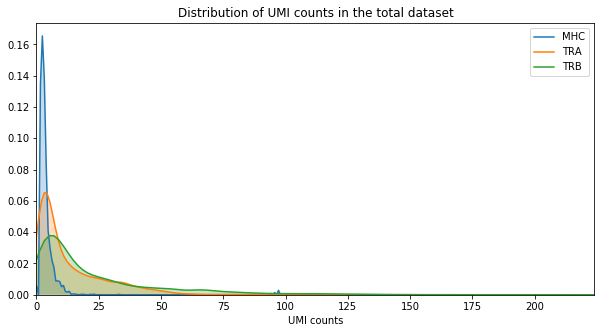

In [60]:
plt.figure(figsize=(10,5))
ax = sns.distplot(df.umi_count_mhc.dropna(), hist=False, kde=True, kde_kws={'shade':True}, label='MHC')
ax = sns.distplot(df.umi_count_TRA.dropna(), hist=False, kde=True, kde_kws={'shade':True}, label='TRA')
ax = sns.distplot(df.umi_count_TRB.dropna(), hist=False, kde=True, kde_kws={'shade':True}, label='TRB')
plt.xlim(0, df.umi_count_TRB.max())
plt.title('Distribution of UMI counts in the total dataset')
plt.xlabel('UMI counts')
plt.show()

In [32]:
reference[(reference.umi_count_mhc == 1) & (reference.umi_count_TRA == 1) & (reference.umi_count_TRB == 1)]

,gem,ct,cdr3_TRA,cdr3_TRB,peptide_HLA,peptide,umi_count_mhc,umi_count_TRA,umi_count_TRB
608,CACACTCCACCCTATC-1,2965.0,CACDNYGQNFVF,CASSAEGGYEQYF,RLLASLQDL A0201,RLLASLQDL,1.0,1.0,1.0
1575,GGACATTGTTACGTCA-1,637.0,CAHNQGGKLIF,CASSQARDPQATQYF,VTEHDTLLY A0101,VTEHDTLLY,1.0,1.0,1.0


## Space of imputations and reference

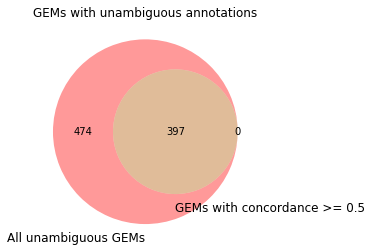

In [26]:
a = set(df[(df.multiplets_mhc == 1) & (df.chain_count_TRA == 1) & (df.chain_count_TRB == 1)].gem)
b = set(df[(df.multiplets_mhc == 1) & (df.chain_count_TRA == 1) & (df.chain_count_TRB == 1 ) & (df.binding_concordance >= 0.5)].gem)

ab = len(a.intersection(b))
a_b = len(a) - ab
b_a = len(b) - ab

title = "GEMs with unambiguous annotations"
venn2(subsets = (a_b, b_a, ab), set_labels = ('All unambiguous GEMs', 'GEMs with concordance >= 0.5'))
plt.title(title)
plt.show()

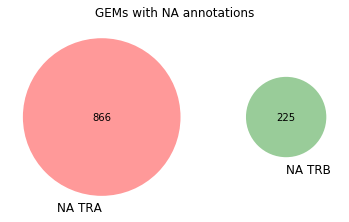

In [42]:
a = set(df[(df.chain_count_TRA == 0) & (df.chain_count_TRB >= 1)].gem)
b = set(df[(df.chain_count_TRA >= 1) & (df.chain_count_TRB == 0)].gem)

ab = len(a.intersection(b))
a_b = len(a) - ab
b_a = len(b) - ab

title = "GEMs with NA annotations"
venn2(subsets = (a_b, b_a, ab), set_labels = ('NA TRA', 'NA TRB'))
plt.title(title)
plt.show()

/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


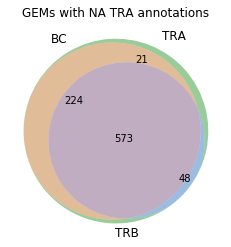

In [43]:
a = set(df[(df.multiplets_mhc >= 1) & (df.chain_count_TRA == 0) & (df.chain_count_TRB == 1)].gem)
b = set(df[(df.multiplets_mhc >= 1) & (df.chain_count_TRA == 0) & (df.chain_count_TRB >= 1)].gem)
c = set(df[(df.multiplets_mhc == 1) & (df.chain_count_TRA == 0) & (df.chain_count_TRB >= 1)].gem)

ab = a.intersection(b)
ac = a.intersection(c)
bc = b.intersection(c)

abc = len(ab.intersection(c))
ab_c = len(ab) - abc
ac_b = len(ac) - abc
bc_a = len(bc) - abc
a_bc = len(a) - ab_c - ac_b - abc
b_ac = len(b) - ab_c - bc_a - abc
c_ab = len(c) - ac_b - bc_a - abc

venn3(subsets = (a_bc, b_ac, ab_c, c_ab, ac_b, bc_a, abc), set_labels = ('BC', 'TRA', 'TRB'))
title = "GEMs with NA TRA annotations"
plt.title(title)
plt.show()

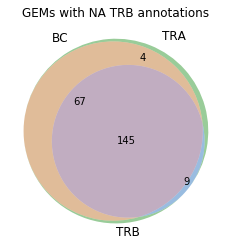

In [44]:
a = set(df[(df.multiplets_mhc >= 1) & (df.chain_count_TRA == 1) & (df.chain_count_TRB == 0)].gem)
b = set(df[(df.multiplets_mhc >= 1) & (df.chain_count_TRA >= 1) & (df.chain_count_TRB == 0)].gem)
c = set(df[(df.multiplets_mhc == 1) & (df.chain_count_TRA >= 1) & (df.chain_count_TRB == 0)].gem)

ab = a.intersection(b)
ac = a.intersection(c)
bc = b.intersection(c)

abc = len(ab.intersection(c))
ab_c = len(ab) - abc
ac_b = len(ac) - abc
bc_a = len(bc) - abc
a_bc = len(a) - ab_c - ac_b - abc
b_ac = len(b) - ab_c - bc_a - abc
c_ab = len(c) - ac_b - bc_a - abc

venn3(subsets = (a_bc, b_ac, ab_c, c_ab, ac_b, bc_a, abc), set_labels = ('BC', 'TRA', 'TRB'))
title = "GEMs with NA TRB annotations"
plt.title(title)
plt.show()

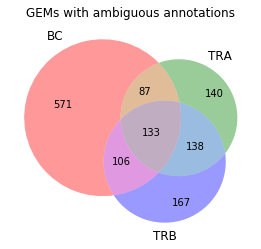

In [60]:
a = set(df[(df.multiplets_mhc > 1) & (df.chain_count_TRA >= 1) & (df.chain_count_TRB >= 1)].gem)
b = set(df[(df.multiplets_mhc >= 1) & (df.chain_count_TRA > 1) & (df.chain_count_TRB >= 1)].gem)
c = set(df[(df.multiplets_mhc >= 1) & (df.chain_count_TRA >= 1) & (df.chain_count_TRB > 1)].gem)

ab = a.intersection(b)
ac = a.intersection(c)
bc = b.intersection(c)

abc = len(ab.intersection(c))
ab_c = len(ab) - abc
ac_b = len(ac) - abc
bc_a = len(bc) - abc
a_bc = len(a) - ab_c - ac_b - abc
b_ac = len(b) - ab_c - bc_a - abc
c_ab = len(c) - ac_b - bc_a - abc

venn3(subsets = (a_bc, b_ac, ab_c, c_ab, ac_b, bc_a, abc), set_labels = ('BC', 'TRA', 'TRB'))
title = "GEMs with ambiguous annotations"
plt.title(title)
plt.show()

In [113]:
660+211+571+87+140+133+106+138+167+819+132

3164

## Filter statistics

In [136]:
# Total number of GEMs
df.shape[0]

1072

In [137]:
# Number of unique GEMs
((df.multiplets_mhc == 1) &
 (df.chain_count_TRA == 1) &
 (df.chain_count_TRB == 1)).sum()

334

In [138]:
((df.multiplets_mhc == 1) &
 (df.chain_count_TRA == 1) &
 (df.chain_count_TRB == 1 ) &
 (df.binding_concordance == 1)).sum()

126

In [139]:
# Number of un-imputable GEMs
((df.multiplets_mhc > 1) &
 (df.chain_count_TRA > 1) &
 (df.chain_count_TRB > 1)).sum()

79

In [140]:
# Number of possible TRA imputations
((df.multiplets_mhc == 1) &
 (df.chain_count_TRA > 1) &
 (df.chain_count_TRB == 1 )).sum()

53

In [141]:
# Number of possible TRB imputations
((df.multiplets_mhc == 1) &
 (df.chain_count_TRA == 1) &
 (df.chain_count_TRB > 1 )).sum()

65

In [142]:
# Number of possible TCR multiplet imputations
((df.multiplets_mhc == 1) &
 (df.chain_count_TRA > 1) &
 (df.chain_count_TRB > 1)).sum()

50

In [143]:
# Number of possible barcode multiplet imputations
((df.multiplets_mhc > 1) &
 (df.chain_count_TRA == 1) &
 (df.chain_count_TRB == 1)).sum()

370

In [144]:
# Number of un-imputable GEMs
((df.multiplets_mhc > 1) &
 (df.chain_count_TRA > 1) &
 (df.chain_count_TRB == 1)).sum()

53

In [145]:
# Number of un-imputable GEMs
((df.multiplets_mhc > 1) &
 (df.chain_count_TRA == 1) &
 (df.chain_count_TRB > 1)).sum()

68

In [146]:
334 + 79 + 53 + 65 + 50 + 370 + 53 + 68

1072

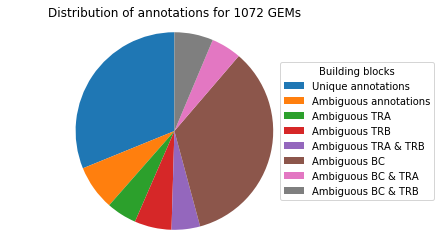

In [29]:
labels = ['Unique annotations', 'Ambiguous annotations', 'Ambiguous TRA', 'Ambiguous TRB', 'Ambiguous TRA & TRB', 'Ambiguous BC', 'Ambiguous BC & TRA', 'Ambiguous BC & TRB']
sizes = [334,79, 53, 65, 50, 370, 53, 68]
fig1, ax1 = plt.subplots()
wedges, text = ax1.pie(sizes, shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of annotations for 1072 GEMs')

ax1.legend(wedges, labels,
          title="Building blocks",
          loc="center left",
          bbox_to_anchor=(0.8, 0, 0.5, 1))

plt.show()